In [1]:
import tensorflow_datasets as tfds

print("TensorFlow Datasets library imported successfully.")

TensorFlow Datasets library imported successfully.


In [2]:
dataset, info = tfds.load(
    'imdb_reviews',
    with_info=True,
    as_supervised=True
)

train_dataset, test_dataset = dataset['train'], dataset['test']

print("IMDb dataset loaded successfully.")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CZT57C_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CZT57C_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.CZT57C_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
IMDb dataset loaded successfully.


In [3]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_e

In [4]:
print("Displaying a few examples from the training dataset:")
for example, label in train_dataset.take(5):
    print(f"Review: {example.numpy().decode('utf-8')[:100]}...")
    print(f"Label: {label.numpy()}")
    print("\n---\n")

Displaying a few examples from the training dataset:
Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. ...
Label: 0

---

Review: I have been known to fall asleep during films, but this is usually due to a combination of things in...
Label: 0

---

Review: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brenn...
Label: 0

---

Review: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with i...
Label: 1

---

Review: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. Th...
Label: 1

---



In [5]:
import tensorflow as tf

print("TensorFlow library imported successfully.")

TensorFlow library imported successfully.


In [7]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 256

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH
)

train_text = train_dataset.map(lambda text, label: text)

vectorize_layer.adapt(train_text)

def preprocess_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

preprocessed_train_dataset = train_dataset.map(preprocess_text)
preprocessed_test_dataset = test_dataset.map(preprocess_text)

preprocessed_train_dataset = preprocessed_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
preprocessed_test_dataset = preprocessed_test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Text preprocessing completed, datasets are ready for model training.")

Text preprocessing completed, datasets are ready for model training.


In [16]:
EMBEDDING_DIM = 128
RNN_UNITS = 64

model = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int32),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.SimpleRNN(RNN_UNITS),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("RNN Model created and compiled successfully.")
model.summary()

RNN Model created and compiled successfully.


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,292,417 (4.93 MB)

 Trainable params: 1,292,417 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
EPOCHS = 10
history_rnn = model.fit(
    preprocessed_train_dataset,
    epochs=EPOCHS,
    validation_data=preprocessed_test_dataset
)

print("RNN model training completed.")

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - accuracy: 0.5016 - loss: 0.6970 - val_accuracy: 0.5042 - val_loss: 0.6943
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 63ms/step - accuracy: 0.5614 - loss: 0.6791 - val_accuracy: 0.5047 - val_loss: 0.7076
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 64ms/step - accuracy: 0.5743 - loss: 0.6454 - val_accuracy: 0.5038 - val_loss: 0.7556
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 74ms/step - accuracy: 0.6245 - loss: 0.5631 - val_accuracy: 0.5038 - val_loss: 0.8206
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 74s 63ms/step - accuracy: 0.6535 - loss: 0.5057 - val_accuracy: 0.5021 - val_loss: 0.9020
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 59s 73ms/step - accuracy: 0.6507 - loss: 0.5156 - val_accuracy: 0.5064 - val_loss: 0.9452
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - accuracy: 0.6570 - loss: 0.4871 - val_accuracy: 0.5006 - val_loss: 0.9873
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.6530 - loss: 0.4864 - 

In [18]:
EMBEDDING_DIM = 128
RNN_UNITS = 64

model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int32),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.LSTM(RNN_UNITS),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("LSTM Model created and compiled successfully.")
model_lstm.summary()

EPOCHS = 10
history_lstm = model_lstm.fit(
    preprocessed_train_dataset,
    epochs=EPOCHS,
    validation_data=preprocessed_test_dataset
)

print("LSTM model training completed.")

LSTM Model created and compiled successfully.


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 153ms/step - accuracy: 0.5068 - loss: 0.6927 - val_accuracy: 0.5301 - val_loss: 0.6839
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 153ms/step - accuracy: 0.5757 - loss: 0.6526 - val_accuracy: 0.7150 - val_loss: 0.5929
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - accuracy: 0.6762 - loss: 0.5888 - val_accuracy: 0.7698 - val_loss: 0.4754
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 128ms/step - accuracy: 0.8700 - loss: 0.3299 - val_accuracy: 0.8448 - val_loss: 0.3840
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 103s 129ms/step - accuracy: 0.9294 - loss: 0.1956 - val_accuracy: 0.8530 - val_loss: 0.3977
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 127ms/step - accuracy: 0.9591 - loss: 0.1293 - val_accuracy: 0.8499 - val_loss: 0.4573
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 120s 151ms/step - accuracy: 0.9750 - loss: 0.0874 - val_accuracy: 0.8421 - val_loss: 0.5028
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 123s 126ms/step - accuracy: 0.9841 -

In [19]:
EMBEDDING_DIM = 128
RNN_UNITS = 64

model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int32),
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM),
    tf.keras.layers.GRU(RNN_UNITS),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("GRU Model created and compiled successfully.")
model_gru.summary()

EPOCHS = 10
history_gru = model_gru.fit(
    preprocessed_train_dataset,
    epochs=EPOCHS,
    validation_data=preprocessed_test_dataset
)

print("GRU model training completed.")

GRU Model created and compiled successfully.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 110s 136ms/step - accuracy: 0.5127 - loss: 0.6934 - val_accuracy: 0.5100 - val_loss: 0.6956
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 135ms/step - accuracy: 0.5592 - loss: 0.6734 - val_accuracy: 0.5255 - val_loss: 0.6946
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 137ms/step - accuracy: 0.7201 - loss: 0.4893 - val_accuracy: 0.8636 - val_loss: 0.3282
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 135ms/step - accuracy: 0.9321 - loss: 0.1813 - val_accuracy: 0.8600 - val_loss: 0.3721
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 137ms/step - accuracy: 0.9705 - loss: 0.0936 - val_accuracy: 0.8484 - val_loss: 0.4700
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 109s 137ms/step - accuracy: 0.9870 - loss: 0.0435 - val_accuracy: 0.8493 - val_loss: 0.5639
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 141s 135ms/step - accuracy: 0.9945 - loss: 0.0228 - val_accuracy: 0.8493 - val_loss: 0.6209
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 107s 134ms/step - accuracy: 0.9972 -

In [20]:
print("Evaluating RNN model:")
rnn_results = model.evaluate(preprocessed_test_dataset)
print("RNN Test Loss, Test Accuracy:", rnn_results)

print("\nEvaluating LSTM model:")
lstm_results = model_lstm.evaluate(preprocessed_test_dataset)
print("LSTM Test Loss, Test Accuracy:", lstm_results)

print("\nEvaluating GRU model:")
gru_results = model_gru.evaluate(preprocessed_test_dataset)
print("GRU Test Loss, Test Accuracy:", gru_results)


Evaluating RNN model:
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5074 - loss: 1.0470
RNN Test Loss, Test Accuracy: [1.0653375387191772, 0.5054799914360046]

Evaluating LSTM model:
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8377 - loss: 0.4818
LSTM Test Loss, Test Accuracy: [0.4796549677848816, 0.8385999798774719]

Evaluating GRU model:
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.8526 - loss: 0.7800
GRU Test Loss, Test Accuracy: [0.7767495512962341, 0.8511999845504761]


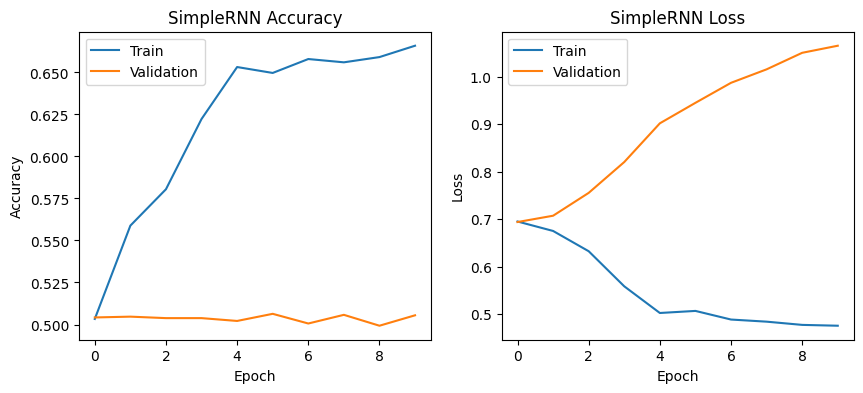

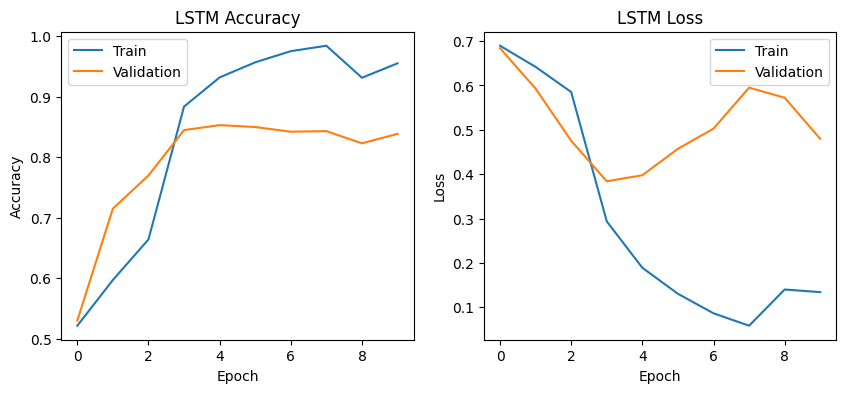

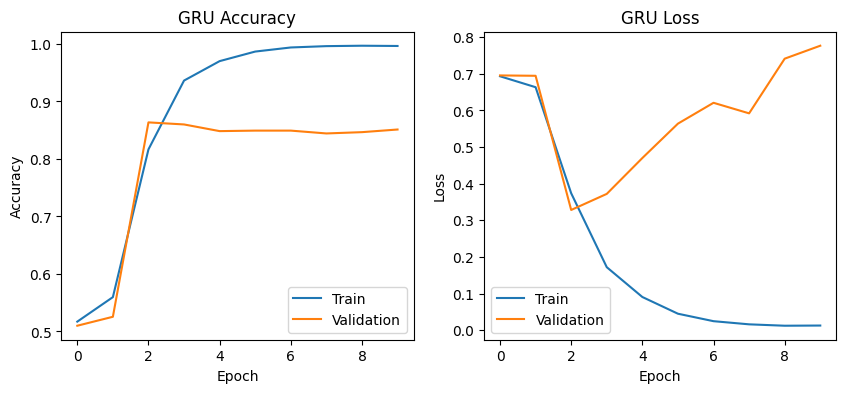

In [21]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.show()

plot_history(history_rnn, "SimpleRNN")
plot_history(history_lstm, "LSTM")
plot_history(history_gru, "GRU")


In [22]:
def predict_review(model, text):
    text_tensor = tf.convert_to_tensor([text])
    text_tensor = tf.expand_dims(text_tensor, -1)
    vectorized = vectorize_layer(text_tensor)
    prediction = model.predict(vectorized)[0][0]

    sentiment = "Positive" if prediction > 0.5 else "Negative"
    print(f"Review: {text}")
    print(f"Prediction Score: {prediction:.4f} → Sentiment: {sentiment}")

predict_review(model_lstm, "This movie was absolutely wonderful! I loved the characters.")
predict_review(model_lstm, "The movie was terrible, boring and too long.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Review: This movie was absolutely wonderful! I loved the characters.
Prediction Score: 0.9868 → Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Review: The movie was terrible, boring and too long.
Prediction Score: 0.0111 → Sentiment: Negative


In [23]:
model.save("sentiment_rnn.h5")
model_lstm.save("sentiment_lstm.h5")
model_gru.save("sentiment_gru.h5")

print("All models saved successfully.")


All models saved successfully.


In [24]:
loaded_lstm = tf.keras.models.load_model("sentiment_lstm.h5")

print("Loaded LSTM model:")
loaded_lstm.summary()


Loaded LSTM model:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 256, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,475 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [25]:
import pandas as pd

df_results = pd.DataFrame({
    "Model": ["RNN", "LSTM", "GRU"],
    "Accuracy": [rnn_results[1], lstm_results[1], gru_results[1]],
    "Loss": [rnn_results[0], lstm_results[0], gru_results[0]]
})

print(df_results)


  Model  Accuracy      Loss
0   RNN   0.50548  1.065338
1  LSTM   0.83860  0.479655
2   GRU   0.85120  0.776750
